In [2]:
import gensim
import torch
from torch.utils.data import DataLoader, TensorDataset
import nltk
import pandas as pd
from collections import Counter
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
data_file = ['./rt-polaritydata/rt-polarity-pos.txt','./rt-polaritydata/rt-polarity-neg.txt']

# 使用Word2vec

In [ ]:
model_name = 'GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(model_name, binary=True)

# Glove词向量转成word2vec

In [116]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_file = 'glove.42B.300d.txt'
glove_word2vec = 'glove.42B.300d_word2vec.txt'
(count, dim)=glove2word2vec(glove_file,glove_word2vec)

In [117]:
count ,dim

(1917494, 300)

# 使用Glove

In [4]:
glove_word2vec = 'glove.42B.300d_word2vec.txt'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(glove_word2vec, binary=False)

In [5]:
vocab2num = Counter()
lengths = []
for i in range(2):
    with open(data_file[i],'r',encoding='utf-8-sig')as f:
        for line in f.readlines():
            sentence = line.strip().lower()
            vocabs = nltk.wordpunct_tokenize(sentence)
            lengths.append(len(vocabs))
            for vocab in vocabs:
                vocab2num[vocab] +=1
with open('./vocab.txt','w',encoding='utf-8')as f:
    f.write('%s\t10000000\n'%'<PAD>')
    for vocab,num in vocab2num.most_common():
        f.write('%s\t%s\n' %(vocab,num))

In [6]:
print("Vocab Size of all train data {}".format(len(vocab2num)))
print("Train Data Size {}".format(len(lengths)))
print("Average Sentence Length {}".format(sum(lengths) / len(lengths)))
print("Max Sentence Length {}".format(max(lengths)))

Vocab Size of all train data 18423
Train Data Size 10661
Average Sentence Length 22.839883688209362
Max Sentence Length 68


In [7]:
max_length = 68
PAD = 0

In [8]:
with open("./vocab.txt", "r", encoding="utf-8") as fr:
    vocabs = [line.split()[0] for line in fr.readlines() if int(line.split()[1]) >= 1]
vocab2idx = {vocab: idx for idx, vocab in enumerate(vocabs)}

In [9]:
x_list = []
y_list = []
for i in range(2):
    count = 0
    with open(data_file[i],'r',encoding='utf-8')as f:
        for line in f.readlines():
            count+=1
            sentence = line.strip().lower()
            x = [vocab2idx.get(vocab) for vocab in nltk.wordpunct_tokenize(sentence) if vocab in vocab2idx]
            x = x[:max_length]
            n_pad = max_length - len(x)
            x = x + n_pad * [PAD]
            x_list.append(x)
        y_list = y_list + [i] *  count
X = np.array(x_list,dtype=np.int64)
Y = np.array(y_list,dtype=np.int64)

In [10]:
print(X.shape,Y.shape)

(10661, 68) (10661,)


In [11]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.1,random_state=1)

In [12]:
vocab_size = len(vocab2idx)
embedding_size = word2vec.vector_size
word_embedding = np.zeros((vocab_size,embedding_size),dtype=np.float32)
idx2vocab = {idx:vocab for vocab,idx in vocab2idx.items()}
for idx in range(1,vocab_size):
    vocab = idx2vocab[idx]
    try:
        word_embedding[idx] = word2vec[vocab]
    except KeyError:
        word_embedding[idx] = np.random.randn(embedding_size)

In [13]:
train_dataset = TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=64)

In [14]:
class LSTMAttention(nn.Module):
    def __init__(self, word_embedding, hidden_dim):
        super(LSTMAttention, self).__init__()
        self.word_embedding = nn.Embedding.from_pretrained(torch.Tensor(word_embedding), freeze=False)
        self.bilstm = nn.LSTM(input_size=embedding_size,
                              hidden_size=hidden_dim // 2,
                              num_layers=1,
                              batch_first=False,
                              bidirectional=True)
        self.hidden2label = nn.Linear(hidden_dim, 2)
        self.self_attention = nn.Sequential(
            nn.Linear(hidden_dim, 100, bias=False),
            nn.LeakyReLU(),
            nn.Linear(100, 1, bias=False)
        )
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        """LSTMAttention Model Forward.
        Arguments:
            sentences: Tensor with shape (batch_size, max_len)
        Returns:
            logits: Tensor with shape (batch_size, num_classes)

        """
        embeds = self.word_embedding(x)  # (N, L, C)

        embeds = embeds.permute(1, 0, 2)  # (L, N, C)
        lstm_out, _ = self.bilstm(embeds)  # (L, N, C)
        #print(lstm_out.size())
        lstm_out = lstm_out.permute(1, 0, 2)  # (N, L, C) #维度换位
        attention = self.self_attention(lstm_out)  # (N, L, 1)
        attention = attention.permute(0, 2, 1)  # (N, 1, L)
        attention = F.softmax(attention, dim=-1)  # (N, 1, L)
        feats = torch.bmm(attention, lstm_out).squeeze(dim=1)  # (N, C) #矩阵乘法
        feats = self.dropout(feats)
        logits = self.hidden2label(feats)  # (N, num_classes)
        output = F.softmax(logits,dim=1)
        return output


In [15]:
model = LSTMAttention(word_embedding,600)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
loss_func = nn.CrossEntropyLoss()

In [16]:
loss_list =[]
accuracy_list=[]
f1_score_list=[]
for epoch in range(50):
    model.train()
    for batch_x,batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_out = model(batch_x)
        loss = loss_func(batch_out,batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    y_true = []
    y_pred = []
    for batch_x,batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_pred = model(batch_x).argmax(dim=-1)
        for y in batch_pred.cpu().numpy():
            y_pred.append(y)
        for y in batch_y.cpu().numpy():
            y_true.append(y)
    accuracy = metrics.accuracy_score(y_true,y_pred)
    f1_score = metrics.f1_score(y_true,y_pred)
    print("epoch %d\nLoss:%.9f  Test_accuracy: %.9f,  Test_f1_score: %.8f" %(epoch+1,loss,accuracy,f1_score))
    loss_list.append(round(loss.item(),6))
    accuracy_list.append(accuracy)
    f1_score_list.append(f1_score)

epoch 1
Loss:0.590666592  Test_accuracy: 0.721649485,  Test_f1_score: 0.74015748
epoch 2
Loss:0.536725819  Test_accuracy: 0.760074977,  Test_f1_score: 0.75097276
epoch 3
Loss:0.562018096  Test_accuracy: 0.774133083,  Test_f1_score: 0.78150499
epoch 4
Loss:0.584751785  Test_accuracy: 0.784442362,  Test_f1_score: 0.79014599
epoch 5
Loss:0.467326790  Test_accuracy: 0.779756326,  Test_f1_score: 0.75647668
epoch 6
Loss:0.504088044  Test_accuracy: 0.768509841,  Test_f1_score: 0.78688525
epoch 7
Loss:0.462156177  Test_accuracy: 0.792877226,  Test_f1_score: 0.79052133
epoch 8
Loss:0.526983857  Test_accuracy: 0.777881912,  Test_f1_score: 0.79045093
epoch 9
Loss:0.448427320  Test_accuracy: 0.795688847,  Test_f1_score: 0.79118774
epoch 10
Loss:0.499276906  Test_accuracy: 0.801312090,  Test_f1_score: 0.78542510
epoch 11
Loss:0.401758492  Test_accuracy: 0.799437676,  Test_f1_score: 0.80037313
epoch 12
Loss:0.378639102  Test_accuracy: 0.792877226,  Test_f1_score: 0.77922078
epoch 13
Loss:0.343954176

In [17]:
from pandas.core.frame import DataFrame
dic = {}
dic['loss']=loss_list
dic['accuracy']= accuracy_list
dic['f1']=f1_score_list
data = DataFrame(dic)

In [136]:
data

,loss,accuracy,f1
0,0.688526,0.585754,0.607460
1,0.638830,0.663543,0.518121
2,0.533870,0.735708,0.694805
3,0.458715,0.712277,0.644264
4,0.449313,0.743205,0.709746
5,0.373542,0.751640,0.747378
6,0.351475,0.776007,0.761715
7,0.368374,0.776007,0.749738
8,0.318335,0.777882,0.761809
9,0.327865,0.776007,0.774741


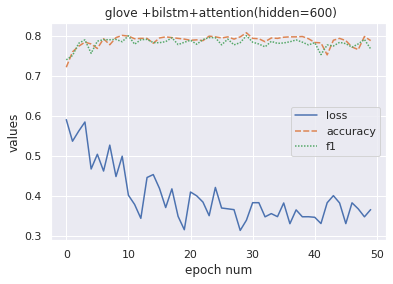

In [18]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
dd =[data['loss'],data['accuracy'],data['f1']]
ax = sns.lineplot(data=dd)
ax.set(xlabel='epoch num', ylabel='values',title=' glove +bilstm+attention(hidden=600)')
plt.show()